In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")

print("Path to dataset files:", path)

100%|██████████| 10.7G/10.7G [08:10<00:00, 23.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashery/chexpert/versions/1


In [51]:
import os
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Transformaciones para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a [-1, 1]
])

class CheXpertDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Obtener todas las rutas de imágenes recorriendo subcarpetas de cada paciente y estudio
        self.image_paths = glob(os.path.join(root_dir, "train", "*", "study*", "*.jpg"))[:20000]
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convertir a escala de grises

        if self.transform:
            image = self.transform(image)

        return image, 0

# Definir dataset y dataloader para train y validacion
dataset_path = "/root/.cache/kagglehub/datasets/ashery/chexpert/versions/1/"
dataset = CheXpertDataset(root_dir=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

valid_dataset_limited = CheXpertDataset(root_dir=dataset_path.replace("train", "valid"), transform=transform)
valid_dataloader = DataLoader(valid_dataset_limited, batch_size=32, shuffle=False)


In [52]:
import torch.nn as nn
import torch.optim as optim


#Me creo una UNet pero sin skipped
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32 -> 16
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh() #probamos con funcion tangente hiperbolica
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


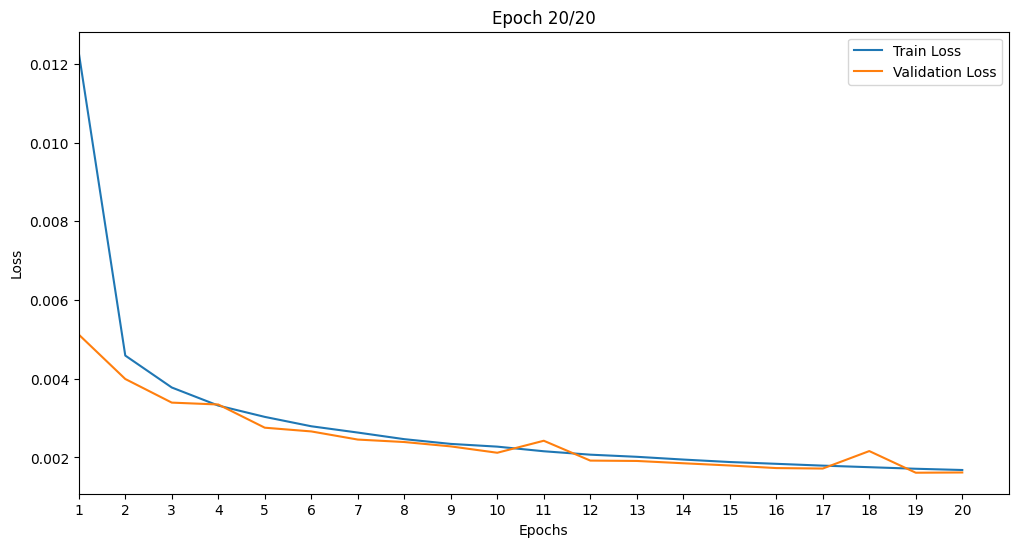

Epoch: 20 | Train Loss: 0.0017 | Val Loss: 0.0016: 100%|██████████| 20/20 [36:43<00:00, 110.17s/it]


In [54]:
#BORRAR

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

# Configuración del dispositivo y otros parámetros
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20

# Inicializar el modelo y el optimizador
model = UNetAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()  # Pérdida de error cuadrado medio

# Arreglos para las pérdidas
t_loss = np.zeros(epochs)
v_loss = np.zeros(epochs)

# Barra de progreso para el entrenamiento
pbar = tqdm(range(1, epochs + 1))

# Bucle de entrenamiento y validación
for epoch in pbar:
    train_loss = 0
    val_loss = 0

    # Etapa de entrenamiento
    model.train()
    for batch_num, (input_img, _) in enumerate(dataloader, 1):
        input_img = input_img.to(device)

        optimizer.zero_grad()
        output = model(input_img)
        loss = criterion(output, input_img)  # Pérdida de reconstrucción
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Etapa de validación
    model.eval()
    with torch.no_grad():
        for input_img, _ in valid_dataloader:
            input_img = input_img.to(device)

            output = model(input_img)
            loss = criterion(output, input_img)  # Pérdida de reconstrucción
            val_loss += loss.item()

    # Promediar las pérdidas por época
    train_loss /= len(dataloader)
    val_loss /= len(valid_dataloader)

    t_loss[epoch - 1] = train_loss
    v_loss[epoch - 1] = val_loss

    # Visualización dinámica de las pérdidas
    plt.figure(figsize=(12, 6))
    plt.plot(t_loss[:epoch], label="Train Loss")
    plt.plot(v_loss[:epoch], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Epoch {epoch}/{epochs}")
    plt.legend()
    plt.xlim(0, epochs)
    plt.xticks(range(0, epochs), range(1, epochs + 1))  # Corregido aquí

    # Limpiar salida y mostrar gráfico actualizado
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()


    # Actualizar la barra de progreso
    pbar.set_description(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


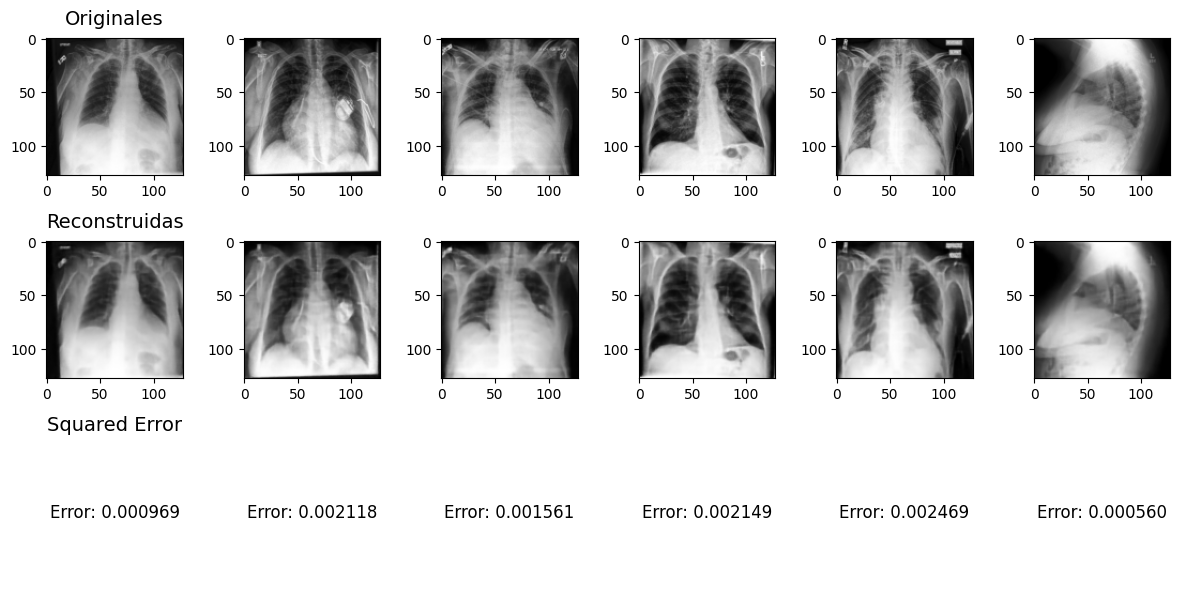

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluación del modelo
model.eval()

# Obtener un batch de imágenes
test_images, _ = next(iter(dataloader))
test_images = test_images.to(device)

# Generar reconstrucciones
reconstructed = model(test_images).cpu().detach()

# Calcular el squared error imagen por imagen
squared_errors = ((test_images.cpu().detach().numpy() - reconstructed.numpy()) ** 2).mean(axis=(1, 2, 3))

# Mostrar algunas imágenes y sus errores
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for i in range(6):
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap="gray")
    axes[1, i].imshow(reconstructed[i].squeeze(), cmap="gray")
    axes[2, i].text(0.5, 0.5, f"Error: {squared_errors[i]:.6f}", ha="center", va="center", fontsize=12)
    axes[2, i].axis("off")

# Ajustar títulos sin superposición
axes[0, 0].set_title("Originales", fontsize=14, pad=10)
axes[1, 0].set_title("Reconstruidas", fontsize=14, pad=10)
axes[2, 0].set_title("Squared Error", fontsize=14, pad=10)

plt.tight_layout()  # Evita superposiciones
plt.show()
